## CEMExplainer: MNIST Example
- This notebook showcases an example of how to use the CEMExplainer from [AIX360](https://github.com/IBM/AIX360) to obtain contrastive explanations i.e. *pertinent negatives (PNs)* and *pertinent postitives (PPs)* for predictions made by a model trained on MNIST data. 
- The CEMExplainer is an implementation of the [contrastive explanation method](https://arxiv.org/abs/1802.07623).
- The default location of this notebook is aix360/examples/constrastive/ folder. This notebook uses trained models which are accessed from aix360/models/CEM/ folder.

#### Import statements

In [1]:
import os
import sys
from keras.models import model_from_json
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.datasets import MNISTDataset

Using TensorFlow backend.
C:\Users\RONNYLUSS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\RONNYLUSS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\RONNYLUSS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\RONNYLUSS\Anaconda3\lib\site-packages\tensorflow\python\fra

#### Load MNIST data

In [2]:
# load MNIST data and normalize it in the range [-0.5, 0.5]
data = MNISTDataset()

In [3]:
# print the shape of train and test data
print("MNIST train data range  :", "(", np.min(data.train_data), ",", np.max(data.train_data), ")")
print("MNIST test data range   :", "(", np.min(data.train_data), ",",  np.max(data.train_data), ")")
print("MNIST train data shape  :", data.train_data.shape)
print("MNIST test data shape   :", data.test_data.shape)
print("MNIST train labels shape:", data.test_labels.shape)
print("MNIST test labels shape :", data.test_labels.shape)

MNIST train data range  : ( -0.5 , 0.5 )
MNIST test data range   : ( -0.5 , 0.5 )
MNIST train data shape  : (55000, 28, 28, 1)
MNIST test data shape   : (10000, 28, 28, 1)
MNIST train labels shape: (10000, 10)
MNIST test labels shape : (10000, 10)


#### Load a trained MNIST model
- This notebook uses a trained MNIST model. The code to train this model is available [here](https://github.com/huanzhang12/ZOO-Attack/blob/master/train_models.py). Note that the model outputs logits and does not use a softmax function. 

In [4]:
# path to mnist related models
model_path = '../../aix360/models/CEM'

def load_model(model_json_file, model_wt_file):
    
    # read model json file
    with open(model_json_file, 'r') as f:
        model = model_from_json(f.read())
    
    # read model weights file
    model.load_weights(model_wt_file)
    
    return model
    

# load MNIST model using its json and wt files
mnist_model = load_model(os.path.join(model_path, 'mnist.json'), os.path.join(model_path, 'mnist'))

# print model summary
mnist_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
________________________________________________

####  Load a trained convolutional autoencoder model (optional)
- This notebook uses a trained convolutional autoencoder model. The code to train this model is available [here](https://github.com/chunchentu/autoencoder). 

In [5]:
# load the trained convolutional autoencoder model
ae_model = load_model(os.path.join(model_path, 'mnist_AE_1_decoder.json'), 
                      os.path.join(model_path, 'mnist_AE_1_decoder.h5'))
# print model summary
ae_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 14, 14, 1)         2625      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 1)        

#### Initialize CEM Explainer to explain model predictions

In [6]:
# wrap mnist_model into a framework independent class structure
mymodel = KerasClassifier(mnist_model)

# initialize explainer object
explainer = CEMExplainer(mymodel)

#### Explain an input instance

Predicted class: [3]
Predicted logits: [[-11.279338     0.7362482   -9.008648    19.396715    -8.286125
   14.442826    -1.3170455  -11.587322    -0.99218464   1.0182221 ]]


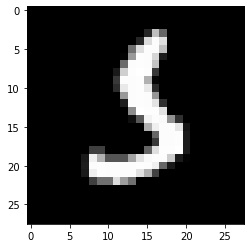

In [7]:
# choose an input image
image_id = 340
input_image = data.test_data[image_id]

# rescale values from [-0.5, 0.5] to [0, 255] for plotting
plt.imshow((input_image[:,:,0] + 0.5)*255, cmap="gray")

# check model prediction
print("Predicted class:", mymodel.predict_classes(np.expand_dims(input_image, axis=0)))
print("Predicted logits:", mymodel.predict(np.expand_dims(input_image, axis=0)))

##### Observation: 

Although the above image is classified as digit 3 by the model, it could have been classified as digit 5 as well since it has similarities to the digit 5. We now employ the CEMExplainer from AIX360 to compute pertinent positive and pertinent negative explanations, which help us understand why the image was classified as digit 3 by the model and not as digit 5. 

#### Obtain Pertinent Negative (PN) explanation

In [8]:
arg_mode = "PN" # Find pertinent negative

arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term

arg_kappa = 0.9 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1.0 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) autoencoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 0.05 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5


(adv_pn, delta_pn, info_pn) = explainer.explain_instance(np.expand_dims(input_image, axis=0), arg_mode, ae_model, arg_kappa, arg_b, 
                                            arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
iter:0 const:[10.]
Loss_Overall:2737.2229, Loss_Attack:58.5389
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:2678.68408203125
target_lab_score:19.3967, max_nontarget_lab_score:14.4428

iter:500 const:[10.]
Loss_Overall:2737.2229, Loss_Attack:58.5389
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:2678.68408203125
target_lab_score:19.3967, max_nontarget_lab_score:14.4428

iter:0 const:[100.]
Loss_Overall:3152.3979, Loss_Attack:0.0000
Loss_L2Dist:12.6054, Loss_L1Dist:16.5280, AE_loss:3123.264404296875
target_lab_score:9.0004, max_nontarget_lab_score:29.0375

iter:500 const:[100.]
Loss_Overall:2977.4849, Loss_Attack:0.0000
Loss_L2Dist:7.0313, Loss_L1Dist:10.1030, AE_loss:2960.3505859375
target_lab_score:9.2486, max_nontarget_lab_score:28.5018

iter:0 const:[55.]
Loss_Overall:2840.0417, Loss_Attack:0.0000
Loss_L2Dist:4.8674, Loss_L1Dist:7.2291, AE_loss:2827.945312

In [9]:
print(info_pn)

[INFO]kappa:0.9, Orig class:3, Perturbed class:5, Delta class: 1, Orig prob:[[-11.279338     0.7362482   -9.008648    19.396715    -8.286125   14.442826    -1.3170455  -11.587322    -0.99218464   1.0182221 ]], Perturbed prob:[[ -6.6616817   -1.9708817   -7.401487    13.478742    -6.3133864   13.78304      1.2838321  -11.600546     0.29793242   1.085611  ]], Delta prob:[[-0.11010491  1.0595146  -0.08893302 -0.25925025 -0.3346461   0.22845559  -0.099649   -0.00456608 -0.31767696 -0.56160116]]


#### Obtain Pertinent Positive (PP) explanation

In [10]:
arg_mode = "PP"  # Find pertinent positive
arg_beta = 0.1 # Controls sparsity of the solution (L1 loss)
(adv_pp, delta_pp, info_pp) = explainer.explain_instance(np.expand_dims(input_image, axis=0), arg_mode, ae_model, arg_kappa, arg_b, 
                                            arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)

iter:0 const:[10.]
Loss_Overall:1186.7104, Loss_Attack:20.4772
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:1166.2332763671875
target_lab_score:-0.1036, max_nontarget_lab_score:1.0441

iter:500 const:[10.]
Loss_Overall:1186.7104, Loss_Attack:20.4772
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:1166.2332763671875
target_lab_score:-0.1036, max_nontarget_lab_score:1.0441

iter:0 const:[100.]
Loss_Overall:1374.8162, Loss_Attack:224.8765
Loss_L2Dist:0.0581, Loss_L1Dist:0.5667, AE_loss:1149.824951171875
target_lab_score:-0.1908, max_nontarget_lab_score:1.1579

iter:500 const:[100.]
Loss_Overall:1179.4254, Loss_Attack:0.0000
Loss_L2Dist:9.2291, Loss_L1Dist:27.3661, AE_loss:1167.4598388671875
target_lab_score:10.4896, max_nontarget_lab_score:3.3207

iter:0 const:[55.]
Loss_Overall:1278.8578, Loss_Attack:112.6245
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:1166.2332763671875
target_lab_score:-0.1036, max_nontarget_lab_score:1.0441

iter:500 const:[55.]
Loss_Overall:1278.8578, Loss_Att

In [11]:
print(info_pp)

[INFO]kappa:0.9, Orig class:3, Perturbed class:3, Delta class: 3, Orig prob:[[-11.279338     0.7362482   -9.008648    19.396715    -8.286125   14.442826    -1.3170455  -11.587322    -0.99218464   1.0182221 ]], Perturbed prob:[[ -5.984942   -0.3156201  -6.267382   11.657149   -3.6047158  11.557238    3.9308367 -11.3727045  -0.803853   -1.8081436]], Delta prob:[[-2.7503839   0.4277636  -1.0708491   4.933249   -1.9914135   1.1908851  -2.4917073  -0.88367814 -1.0458403   1.2483816 ]]


#### Plot Pertinent Negative (PN) and Pertinent Positive (PP) explanations

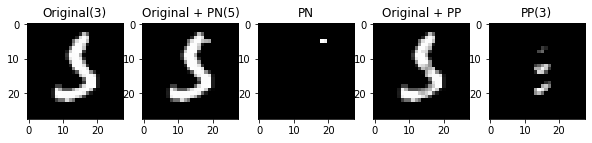

In [12]:
# rescale values from [-0.5, 0.5] to [0, 255] for plotting
fig0 = (input_image[:,:,0] + 0.5)*255

fig1 = (adv_pn[0,:,:,0] + 0.5) * 255
fig2 = (fig1 - fig0) #rescaled delta_pn
fig3 = (adv_pp[0,:,:,0] + 0.5) * 255
fig4 = (delta_pp[0,:,:,0] + 0.5) * 255 #rescaled delta_pp

f, axarr = plt.subplots(1, 5, figsize=(10,10))
axarr[0].set_title("Original" + "(" + str(mymodel.predict_classes(np.expand_dims(input_image, axis=0))[0]) + ")")
axarr[1].set_title("Original + PN" + "(" + str(mymodel.predict_classes(adv_pn)[0]) + ")")
axarr[2].set_title("PN")
axarr[3].set_title("Original + PP")
axarr[4].set_title("PP" + "(" + str(mymodel.predict_classes(delta_pp)[0]) + ")")

axarr[0].imshow(fig0, cmap="gray")
axarr[1].imshow(fig1, cmap="gray")
axarr[2].imshow(fig2, cmap="gray")
axarr[3].imshow(fig3, cmap="gray")
axarr[4].imshow(fig4, cmap="gray")
plt.show()

##### Explanation: 
- The PP highlights the minimum set of pixels which were present in the image for it to be classified as digit 3. Note that both the original image and PP are classified as digit 3 by the classifier. 
- The PN highlights a small horizontal line at the top whose presence would change the classification of the original image to digit 5 and thus should be absent for the classification to remain digit 3. 